### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav

from GDa.session             import session_info, session
from GDa.signal.surrogates   import phase_rand_surrogates

#### Loading data - for correct task trials

In [2]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
# Read data from .mat files
s.read_from_mat()

In [3]:
idx  = s.trial_info[(s.trial_info['trial_type']==1.0) \
                    & (s.trial_info['behavioral_response']==1.0)].trial_index.values

In [4]:
data = s.data.sel(trials=idx)#.isel(roi=[47,48])

#### Generate surrogates

In [37]:
seeds     = np.arange(0, 10, dtype=int) * 100

data_surr = []
for seed in tqdm( seeds ):
    data_surr += [phase_rand_surrogates(data,val=0,seed=seed,verbose=False,n_jobs=-1)]
data_surr = xr.concat(data_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:07<01:05,  7.29s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:11<00:41,  5.19s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 30%|███       | 3/10 [00:15<00:32,  4.70s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 40%|████      | 4/10 [00:18<00:24,  4.10s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [00:22<00:20,  4.17s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [00:26<00:16,  4.12s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [00:30<00:12,  4.11s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [00:34<00:08,  4.05s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [00:38<00:04,  4.03s/it]

  0%|          |  : 0/540 [00:00<?,       ?it/s]

100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


#### Computing coherence

In [28]:
sm_times = 300
sm_freqs = 1
# Downsampling factor
delta = 15       
mode  = 'morlet'
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])
n_freqs      = 50
#freqs        = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
freqs        = np.concatenate( (np.linspace(foi[0,0], foi[0,1], 10, endpoint=False), 
                                np.linspace(foi[1,0], foi[1,1], 10, endpoint=False), 
                                np.linspace(foi[2,0], foi[2,1], 10, endpoint=False), 
                                np.linspace(foi[3,0], foi[3,1], 10, endpoint=False), 
                                np.linspace(foi[4,0], foi[4,1], 10, endpoint=False)  ) )
n_cycles     = freqs/2
decim_at     ='tfd'

In [7]:
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=data.time, roi=data.roi, foi=foi, n_jobs=20,
    sfreq=data.attrs['fsample'], mode=mode, n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=1, decim_at=decim_at
)

In [8]:
coh      = conn_coherence_wav(data, **kw).astype(np.float32)

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   19.0s remaining:    4.3s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   21.9s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [9]:
coh_surr = []
for i in tqdm( range(10) ):
    coh_surr += [conn_coherence_wav(data_surr.isel(seeds=i), **kw).astype(np.float32)]
coh_surr = xr.concat(coh_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.8s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 10%|█         | 1/10 [02:54<26:07, 174.17s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.9s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 20%|██        | 2/10 [05:48<23:15, 174.39s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.6s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 30%|███       | 3/10 [08:44<20:23, 174.85s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.2s remaining:    4.8s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 40%|████      | 4/10 [11:38<17:28, 174.82s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.1s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [14:33<14:34, 174.92s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.7s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [17:27<11:37, 174.33s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.0s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.9s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [20:19<08:41, 173.84s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.3s remaining:    4.8s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [23:14<05:47, 173.92s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.7s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [26:08<02:54, 174.09s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.8s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

100%|██████████| 10/10 [29:03<00:00, 174.30s/it]


In [40]:
#del coh.attrs['mt_bandwidth']
#del coh_surr.attrs['mt_bandwidth']

#coh.to_netcdf('data/coh_orig.nc')
#coh_surr.to_netcdf('data/coh_surr.nc')

In [10]:
bins = np.linspace(0,1,100)
for r in range(coh.sizes['roi']):
    plt.figure(figsize=(8,15))
    count = 1
    for i in range(5):
        plt.subplot(5,1,count)
        plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        for j in range(10):
            if j==0:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
            else:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r');
        plt.hist( coh.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=5);
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
    plt.tight_layout()
    plt.xlabel(f'Coherence', fontsize=15)
    plt.savefig(f'img/surr_dist_roi{r}.png')
    plt.close()

In [18]:
med = np.zeros((coh.sizes['roi'],coh.sizes['freqs']))
for r in range(coh.sizes['roi']):
    for i in range(5):
        m_surr = []
        for j in range(10):
                m_surr += [np.median( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten() )]
        m_surr = np.squeeze(m_surr)
        m_orig = np.median( coh.isel(freqs=i, roi=r).values.flatten() )
        med[r,i] = np.mean( m_orig-m_surr )

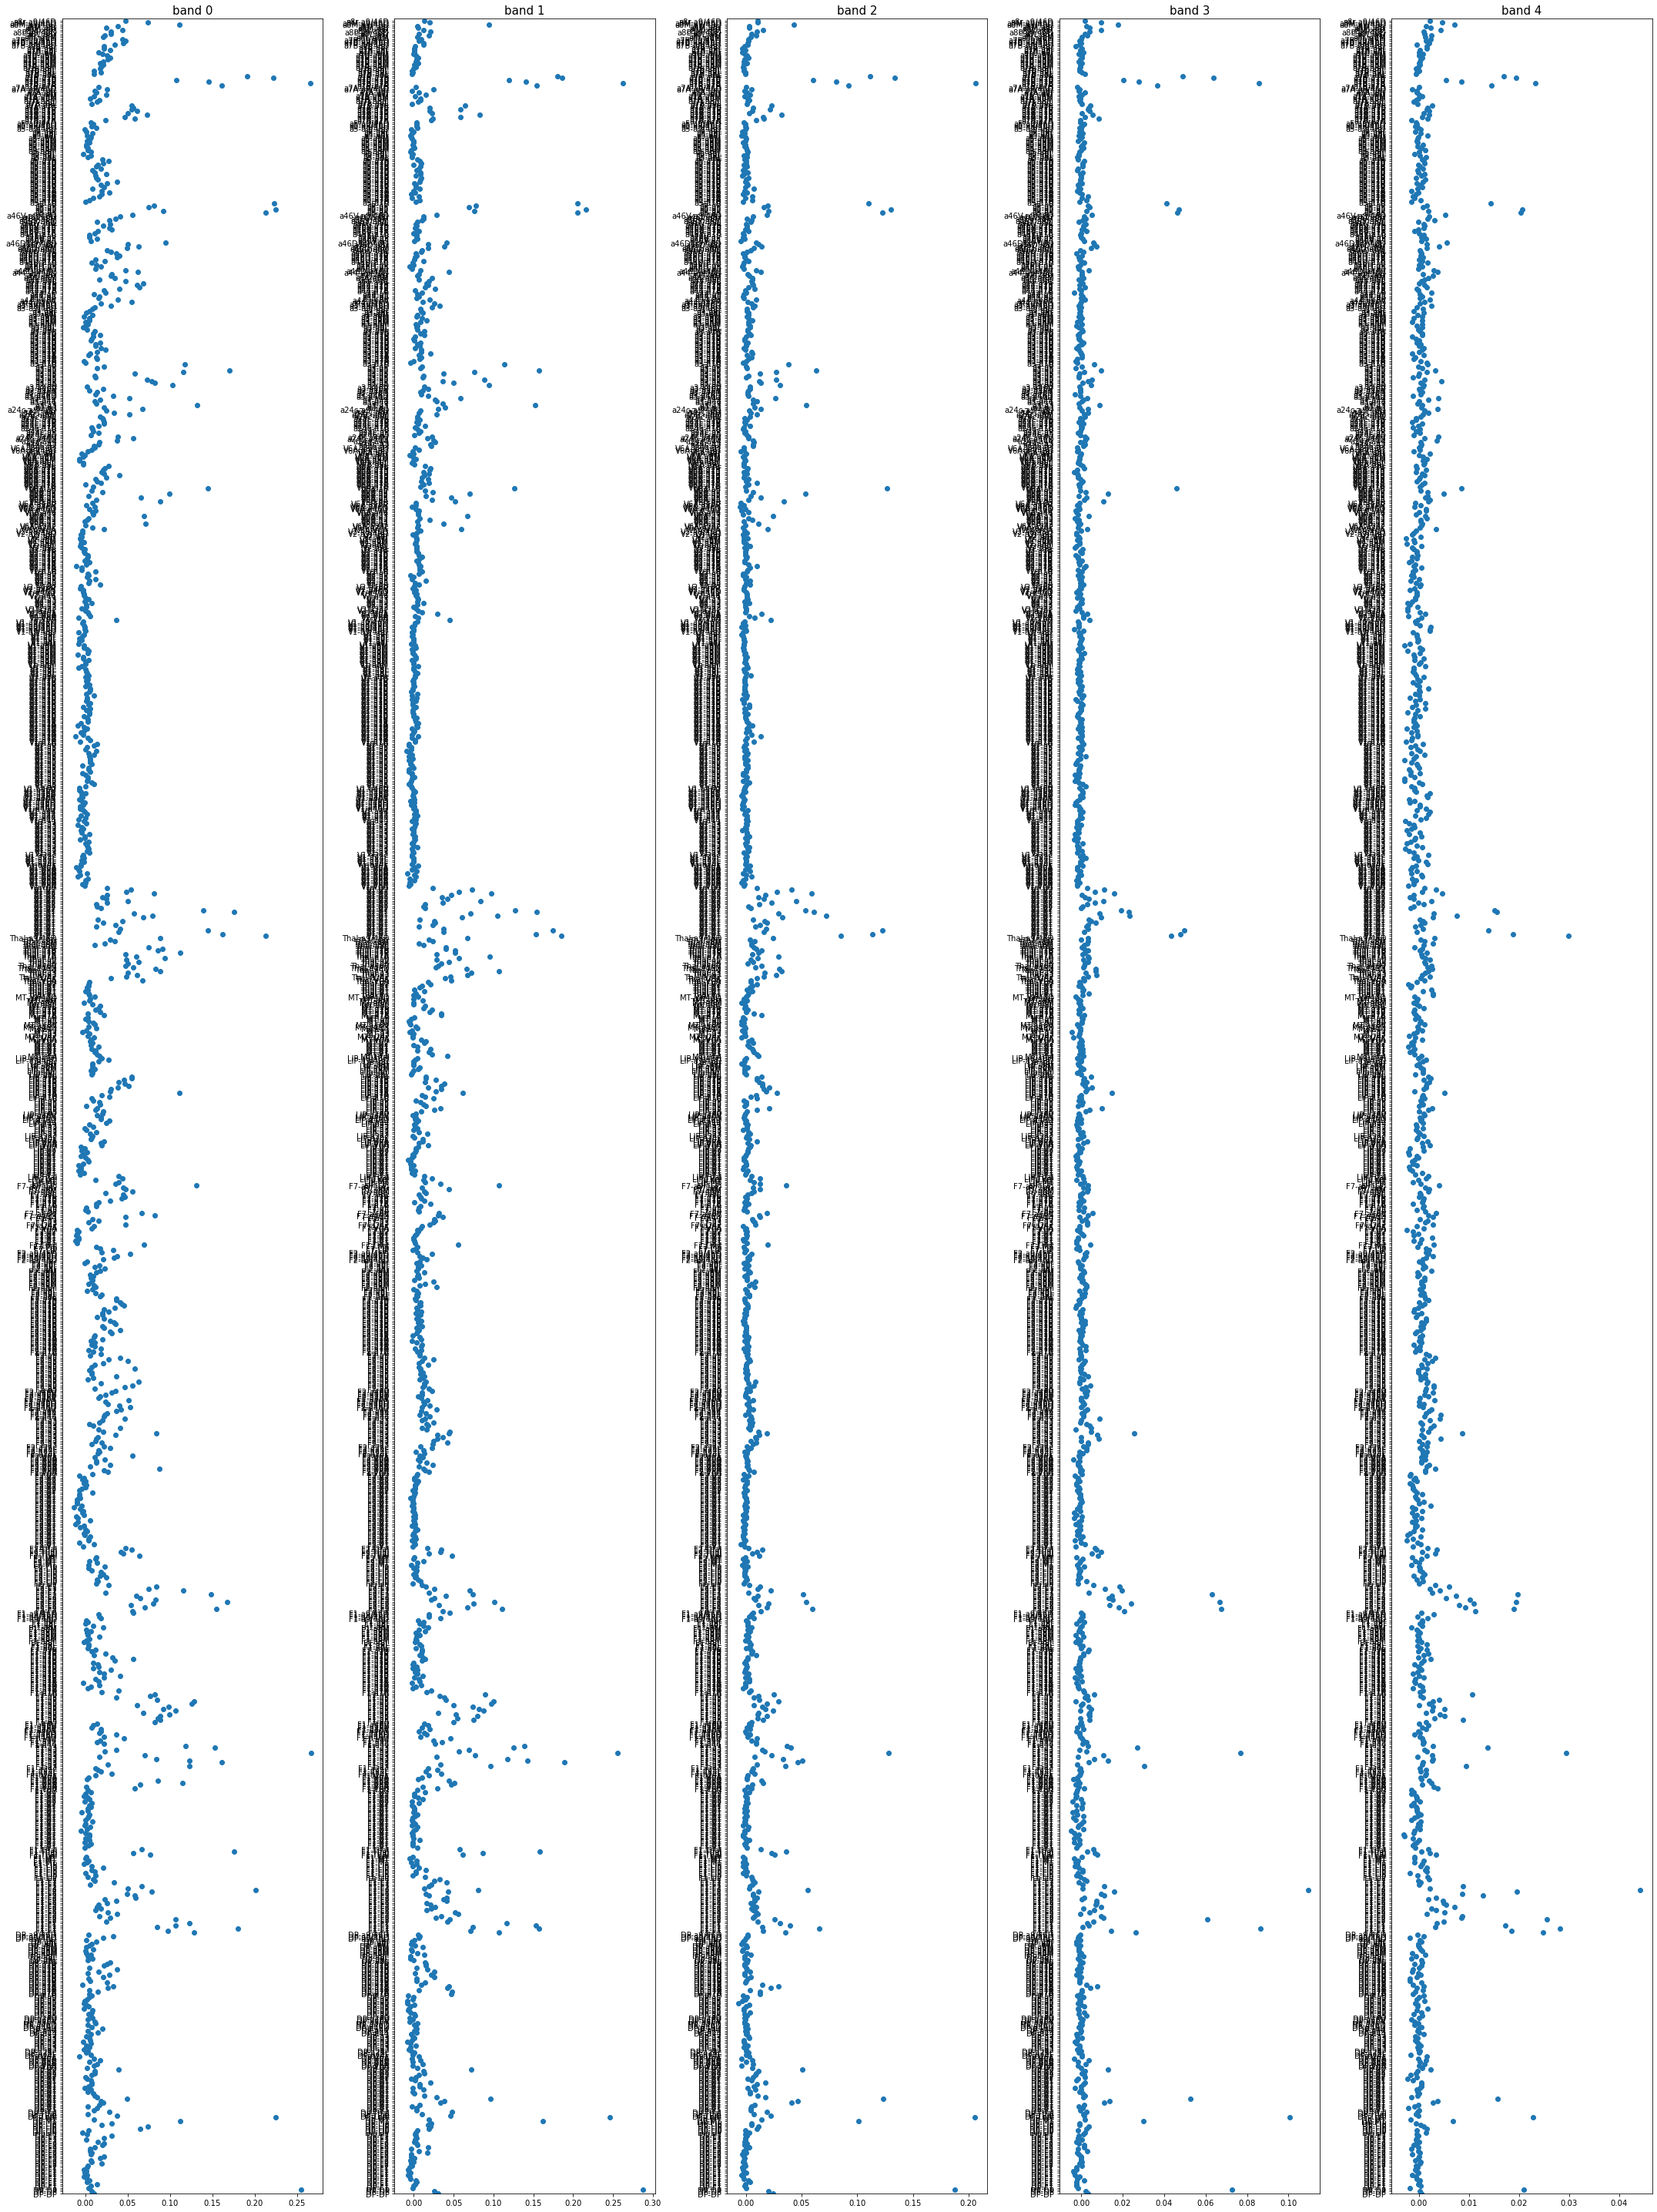

In [37]:
idx = np.argsort(coh.roi.values)
plt.figure(figsize=(30,40))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(med[idx,i], range(coh.sizes['roi']), 'o')
    plt.title(f'band {i}', fontsize=15)
    plt.ylim(0, coh.sizes['roi'])
    plt.yticks(range(coh.sizes['roi']),coh.roi.values[idx])
plt.tight_layout()
plt.savefig('img/surr_median.png')

### Comparing with dFC

In [5]:
from GDa.fc.dFC import dFC

In [6]:
x_s, x_t  = np.triu_indices(data.sizes['roi'], k=1)
pairs     = np.array([x_s,x_t]).T

In [29]:
dfc = []
for f_0,f_1 in foi:
    dfc += [dFC(data,times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=None,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 177 tasks      | elapsed:    2.7s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    7.4s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:    8.3s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    8.9s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.0s
[Parallel(n_jobs=40)]: Done 177 tasks      | elapsed:    3.1s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    3.6s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    5.4s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    7.9s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:    8.8s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    9.4s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.6s
[Parallel(n_jobs=40)]: Done 178 tasks      | elapsed:    3.8s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:    4.4s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    8.5s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:    9.4s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   10.0s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.7s
[Parallel(n_jobs=40)]: Done 129 tasks      | elapsed:    3.8s
[Parallel(n_jobs=40)]: Done 816 tasks      | elapsed:    4.3s
[Parallel(n_jobs=40)]: Done 8360 tasks      | elapsed:    5.7s
[Parallel(n_jobs=40)]: Done 21032 tasks      | elapsed:    8.0s
[Parallel(n_jobs=40)]: Done 25964 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    9.9s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.9s
[Parallel(n_jobs=40)]: Done 175 tasks      | elapsed:    4.1s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:    4.6s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    6.5s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    9.1s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   10.0s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   10.6s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [30]:
dfc = xr.concatat(dfc,dim="freqs")

In [55]:
dfc_surr = []
for f_0,f_1 in foi:
    dfc_surr += [dFC(data_surr.isel(seeds=0),times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=None,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)]


Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.2s
[Parallel(n_jobs=40)]: Done 177 tasks      | elapsed:    3.4s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    3.9s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:    6.6s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:    8.2s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:    9.7s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   10.5s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    3.7s
[Parallel(n_jobs=40)]: Done 174 tasks      | elapsed:    3.8s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    4.2s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    5.9s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    8.3s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:    9.8s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=40)]: Done 173 tasks      | elapsed:    4.2s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:    4.7s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    6.7s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   10.7s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    4.4s
[Parallel(n_jobs=40)]: Done 175 tasks      | elapsed:    4.6s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:    5.1s
[Parallel(n_jobs=40)]: Done 16640 tasks      | elapsed:    8.1s
[Parallel(n_jobs=40)]: Done 25856 tasks      | elapsed:    9.7s
[Parallel(n_jobs=40)]: Done 26324 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   10.6s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=None)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    4.9s
[Parallel(n_jobs=40)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    5.5s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:    7.3s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   11.1s finished
Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

AttributeError: module 'xarray' has no attribute 'concatat'

In [56]:
dfc_surr = xr.concat(dfc_surr,dim="freqs")

In [34]:
dfc = dfc.stack(observations=("trials","times"))

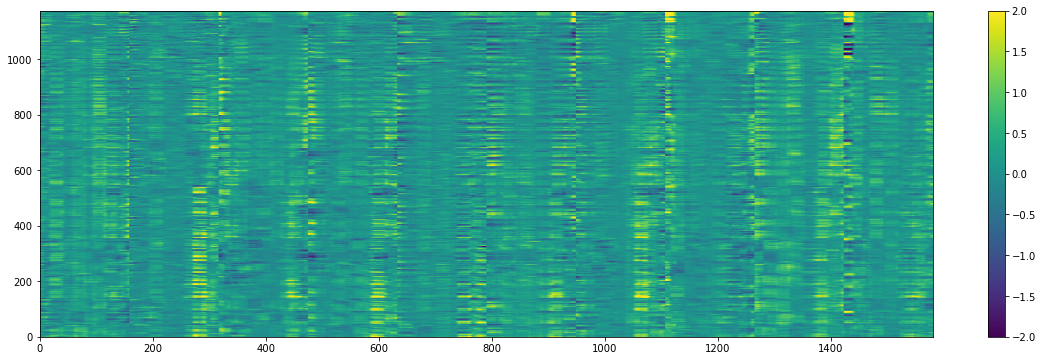

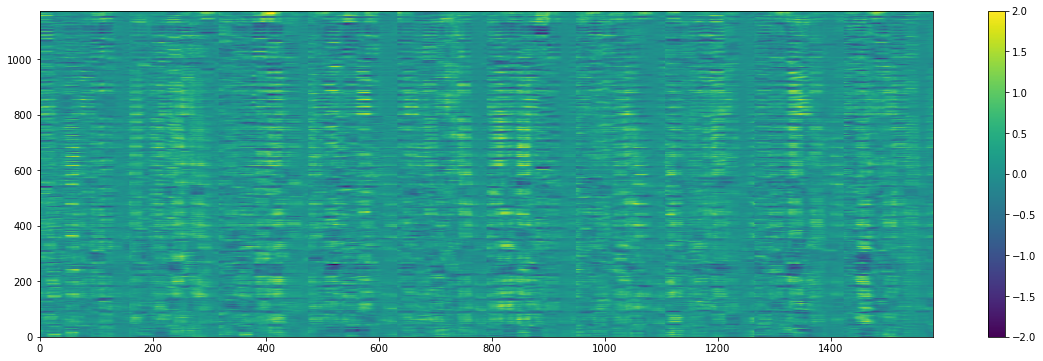

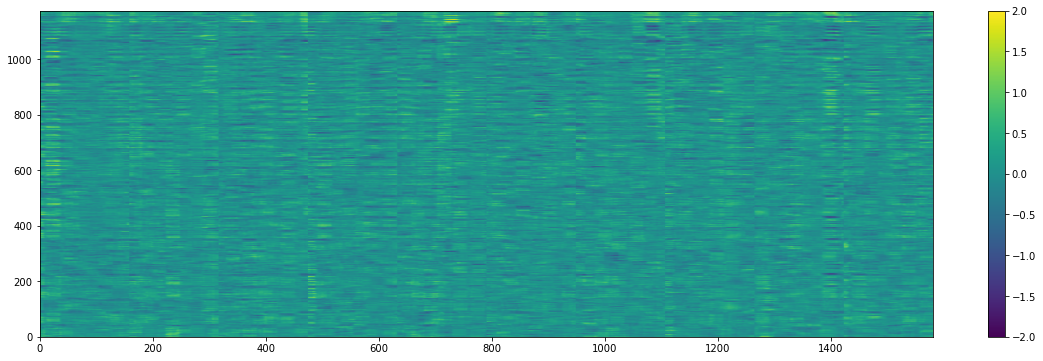

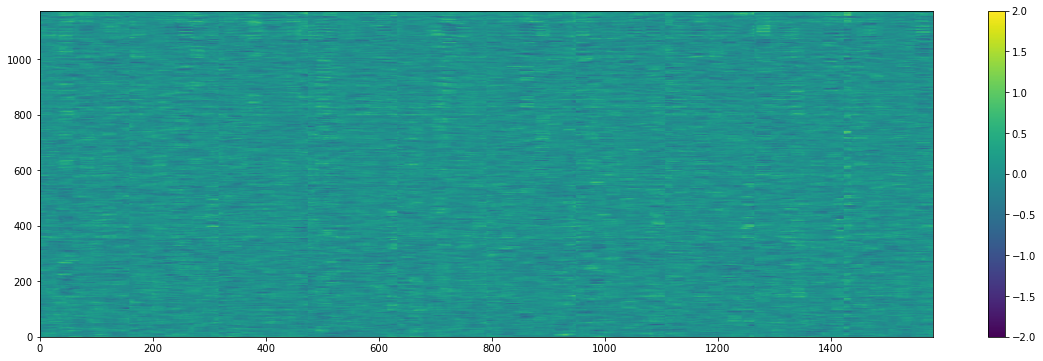

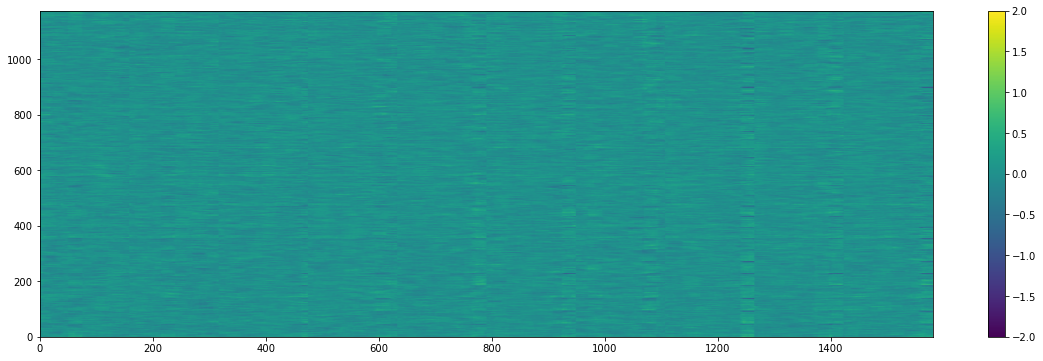

In [39]:
for i in range(5):
    plt.figure(figsize=(20,6))
    plt.imshow( dfc[i,...,:1580], aspect='auto', origin='lower', vmin=-2, vmax=2)
    plt.colorbar()

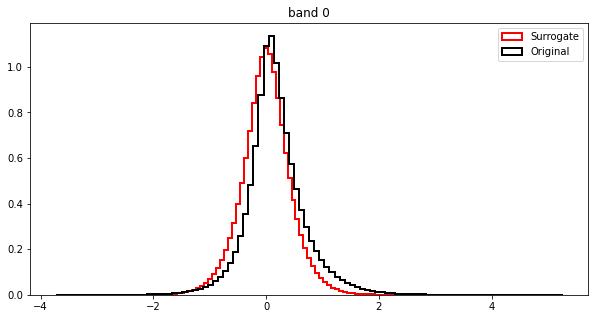

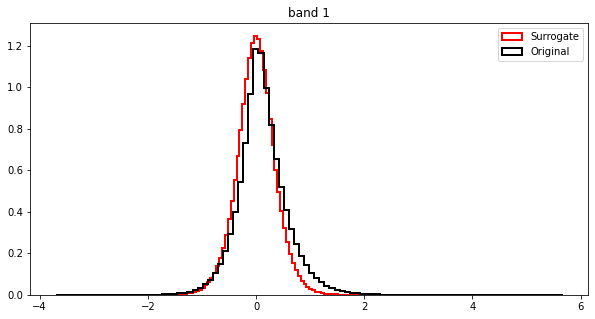

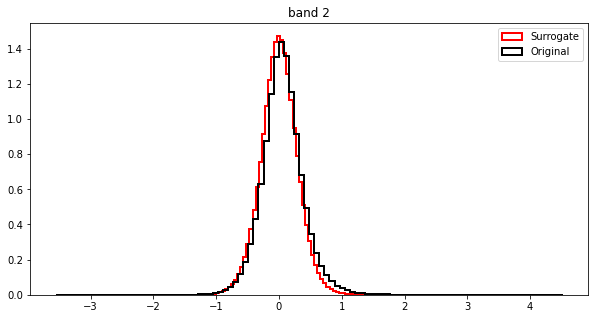

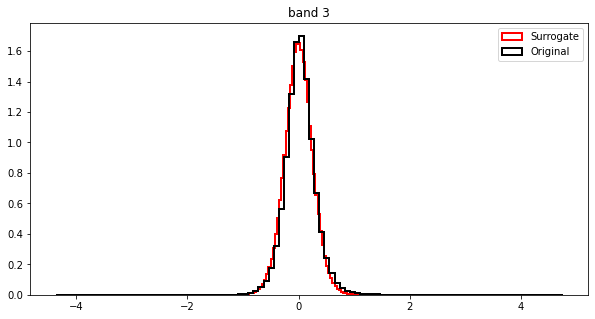

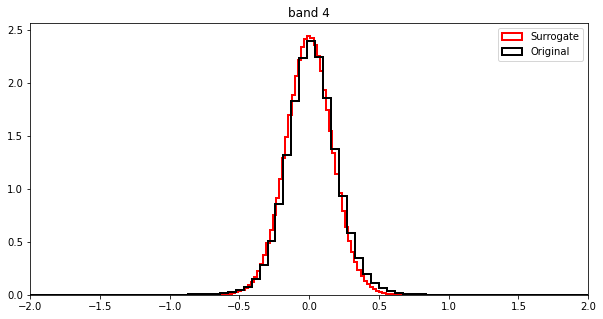

In [60]:
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.hist( dfc_surr.isel(freqs=i).values.flatten(), bins=100,  color='red', label='Surrogate', density=True, histtype='step', fill=False, lw=2)
    plt.hist( dfc.isel(freqs=i).values.flatten(), bins=100,  color='k', label='Original', density=True, histtype='step', fill=False, lw=2)
    plt.title(f'band {i}')
    plt.legend()
plt.xlim(-2,2);